# Introduction

## Retrieval-Augmented Generation (RAG)
Retrieval-Augmented Generation (RAG) is a technique that combines document retrieval and generation capabilities to produce more accurate and contextually relevant responses. In RAG, a retrieval component first fetches relevant documents or passages from a large corpus based on a query. Then, a generation component, typically a large language model, uses the retrieved documents to generate a response. It's particularly valuable in applications like chatbots where the quality of the response is crucial.

## Workflow
The workflow of the Context-Aware ChatBot using RAG consists of the following steps:
1. **Document Loading**: Importing text data from various sources such as URLs.
2. **Document Splitting**: Breaking down large texts into manageable chunks for better retrieval performance.
3. **Vector Storing**: Converting text chunks into vector formats that can be efficiently retrieved.
4. **Retrieval**: Fetching the most relevant text chunks in response to a query.
5. **Question Answering**: Generating responses based on the context provided by the retrieved texts.
6. **Interactive Widgets**: Experiment with different queries interactively.

## Setup and Installation
First, ensure all necessary Python packages are installed to run the examples provided:

In [1]:
!pip install transformers sentence-transformers langchain faiss-cpu ipywidgets

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sentence_transformers import SentenceTransformer
from langchain.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from ipywidgets import widgets, Layout
from transformers import pipeline

/home/tahaei/.local/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
2024-06-14 15:58:47.735100: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-14 15:58:47.844983: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-14 15:58:48.282041: W tensorflow/compile

## Document Loading
We begin by loading documents using LangChain from predetermined URLs which provide a rich dataset for our RAG system:

In [3]:
# List of URLs to load documents from
urls = [
    "https://en.wikipedia.org/wiki/Natural_language_processing",
    "https://en.wikipedia.org/wiki/Artificial_intelligence",
    "https://en.wikipedia.org/wiki/Machine_learning",
    "https://en.wikipedia.org/wiki/Deep_learning",
    "https://en.wikipedia.org/wiki/Data_science"
]

# Initialize the WebBaseLoader with the list of URLs
loader = WebBaseLoader(urls)

# Load documents
documents = loader.load()

print(f"Loaded {len(documents)} documents.")

Loaded 5 documents.


## Document Splitting
To enhance retrieval performance, documents are split into smaller, more manageable chunks:

In [4]:
# Initialize the text splitter
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)

# Split the loaded documents into chunks
chunks = splitter.split_documents(documents)

print(f"Split into {len(chunks)} chunks.")

Split into 722 chunks.


In [5]:
# Function to clean and extract meaningful content from chunks
def clean_chunk(chunk):
    lines = chunk.page_content.split('\n')
    meaningful_lines = [line for line in lines if line.strip() != '' and not line.startswith('Jump to content')]
    return ' '.join(meaningful_lines[:100])

# Print the first 3 chunks as examples
for i, chunk in enumerate(chunks[:3]):
    cleaned_chunk = clean_chunk(chunk)
    print(f"Chunk {i+1}:\n{cleaned_chunk}\n{'-'*40}")

Chunk 1:
Natural language processing - Wikipedia Main menu Main menu move to sidebar hide 		Navigation Main pageContentsCurrent eventsRandom articleAbout WikipediaContact usDonate 		Contribute HelpLearn to editCommunity portalRecent changesUpload file Search Search Appearance Create account Log in Personal tools  Create account Log in 		Pages for logged out editors learn more ContributionsTalk Contents move to sidebar hide (Top) 1 History Toggle History subsection 1.1 Symbolic NLP (1950s – early 1990s) 1.2 Statistical NLP (1990s–2010s) 1.3 Neural NLP (present) 2 Approaches: Symbolic, statistical, neural networks Toggle Approaches: Symbolic, statistical, neural networks subsection 2.1 Statistical approach 2.2 Neural networks
----------------------------------------
Chunk 2:
2 Approaches: Symbolic, statistical, neural networks Toggle Approaches: Symbolic, statistical, neural networks subsection 2.1 Statistical approach 2.2 Neural networks 3 Common NLP tasks Toggle Common NLP tasks subsec

## Vector Stores
Document chunks are then embedded and stored in a vector format to facilitate efficient retrieval:

In [6]:
# Initialize the SentenceTransformer model
model_name = "all-MiniLM-L6-v2"
embedding_model = SentenceTransformer(model_name)

# Wrap the SentenceTransformer model with LangChain
embedding_wrapper = HuggingFaceEmbeddings(model_name=model_name)

# Create embeddings for the chunks
embeddings = embedding_wrapper.embed_documents([chunk.page_content for chunk in chunks])

# Create the vector store
vectorstore = FAISS.from_documents(documents=chunks, embedding=embedding_wrapper)
print("Vector store created with embeddings.")

# Print a few example embeddings to visualize the results
example_vector = vectorstore.index.reconstruct(0)  # Getting the first vector as an example
print(f"Example vector:\n{example_vector[:10]}... (truncated)\n{'-'*40}")

/home/tahaei/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/tahaei/.local/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  warn_deprecated(


Vector store created with embeddings.
Example vector:
[-0.0155906  -0.07476962  0.07039002  0.00700213  0.03098843  0.04333629
 -0.00559796  0.04472222 -0.02328821  0.02334314]... (truncated)
----------------------------------------


Visualizing the embeddings of the document chunks can provide insightful information about the distribution and grouping of data.

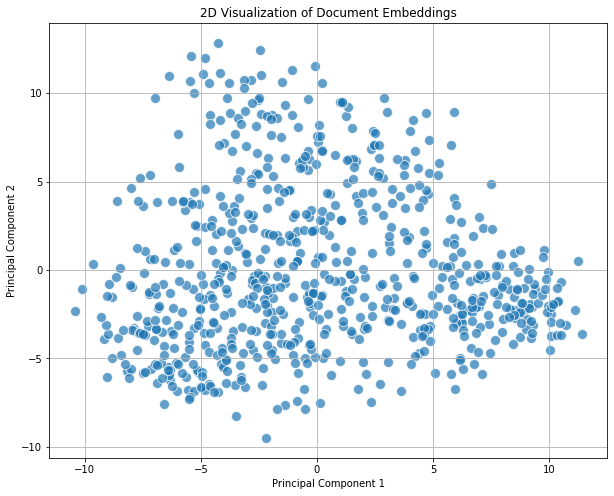

In [7]:
# Ensure that the embeddings are in a suitable array format for PCA
embeddings_array = np.array([emb for emb in embeddings if emb is not None])

# Standardize the embeddings before applying PCA
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings_array)

# Reduce dimensions to 2D for visualization using PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings_scaled)

# Plotting the reduced embeddings
plt.figure(figsize=(10, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.7, edgecolors='w', s=100)
plt.title('2D Visualization of Document Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

This plot illustrates how similar documents are clustered together based on their content, offering a visual confirmation of the effectiveness of the embedding process.

## Retrieval
We employ retrieval techniques to fetch document chunks that are most relevant to user queries:

In [8]:
# Initialize the FAISS retriever
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k":5})

# Initialize a local LLM for generating responses using HuggingFace pipeline
qa_pipeline = pipeline("question-answering", model="distilbert-base-uncased-distilled-squad")

# Define a simple function to generate answers using the QA pipeline
def generate_answer(question, context):
    result = qa_pipeline(question=question, context=context)
    return result['answer']

## Question Answering
Finally, we demonstrate how the chatbot responds to various queries by generating context-aware responses:

In [9]:
questions = [
    "What is Natural Language Processing?",
    "How does machine learning impact data science?",
    "What are the key techniques in artificial intelligence?",
    "What is the future of AI in healthcare?",
    "How does AI contribute to personalizing education?",
    "What are the ethical implications of AI in surveillance?",
    "What are the challenges in developing AI for global languages?"
]

# Process each question and generate an answer
for question in questions:
    # Retrieve relevant document chunks
    retrieved_docs = retriever.get_relevant_documents(question)
    
    # Combine retrieved documents into a single context
    combined_context = " ".join([doc.page_content for doc in retrieved_docs])
    
    # Generate response
    response = generate_answer(question, combined_context)
    print(f"Question: {question}\nAnswer: {response}\n{'-'*80}")

/home/tahaei/.local/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


Question: What is Natural Language Processing?
Answer: providing computers the ability to process data encoded in natural language
--------------------------------------------------------------------------------
Question: How does machine learning impact data science?
Answer: generalizable predictive patterns
--------------------------------------------------------------------------------
Question: What are the key techniques in artificial intelligence?
Answer: search and mathematical optimization, formal logic, artificial neural networks
--------------------------------------------------------------------------------
Question: What is the future of AI in healthcare?
Answer: increase patient care and quality of life
--------------------------------------------------------------------------------
Question: How does AI contribute to personalizing education?
Answer: responsible collection of data and documentation of algorithmic rules
------------------------------------------------------

## Interactive Widgets for Query Input
To enhance user interaction and provide real-time testing capabilities, the following interactive widgets allow you to input a query and generate answers directly within the notebook. This feature is particularly useful for exploring how different queries are handled by the chatbot and to demonstrate the dynamic nature of the retrieval-augmented generation process.

In [10]:
query_input = widgets.Text(
    value='What is Natural Language Processing?',
    description='Query:',
    layout=Layout(width='80%'),
    style={'description_width': 'initial'},
    disabled=False
)
query_button = widgets.Button(description="Generate Answer", button_style='info')

output = widgets.Output()

def on_button_clicked(b):
    with output:
        output.clear_output()
        question = query_input.value
        retrieved_docs = retriever.get_relevant_documents(question)
        combined_context = " ".join([doc.page_content for doc in retrieved_docs])
        response = generate_answer(question, combined_context)
        print(f"Question: {question}\nAnswer: {response}")

query_button.on_click(on_button_clicked)

display(query_input, query_button, output)

Text(value='What is Natural Language Processing?', description='Query:', layout=Layout(width='80%'), style=Tex…

Button(button_style='info', description='Generate Answer', style=ButtonStyle())

Output()